In [1]:
import json
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from sklearn.metrics import precision_recall_curve, f1_score
from tensorflow.keras.callbacks import Callback

# Load dataset and image paths
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data', 'images*', '*', '*.png'))}
print(f'Scans found: {len(all_image_paths)}, Total Headers: {all_xray_df.shape[0]}')

# Map image paths to DataFrame
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
df = all_xray_df.copy()

# Clean and preprocess DataFrame
df.columns = df.columns.str.replace(' ', '_')
df['OriginalImageWidth'] = df.iloc[:, 7]
df['OriginalImageHeight'] = df.iloc[:, 8]
df['OriginalImagePixelSpacing_x'] = df.iloc[:, 9]
df['OriginalImagePixelSpacing_y'] = df.iloc[:, 10]
df = df.iloc[:, :7].join(df[['OriginalImageWidth', 'OriginalImageHeight', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y']])
df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

# One-Hot Encoding for Finding Labels
all_labels = np.unique(list(chain(*df['Finding_Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]
for c_label in all_labels:
    if len(c_label) > 1:  # Leave out empty labels
        df[c_label] = df['Finding_Labels'].map(lambda finding: 1 if c_label in finding else 0)
df.drop(columns=['Finding_Labels'], inplace=True)
df.head(1)

# Preprocess Dataset Function
def preprocess_dataset(df, age_threshold=85):
    # Exclude patients over a certain age
    df = df[df['Patient_Age'] <= age_threshold]
    return df

df = preprocess_dataset(df)


Using TensorFlow backend.


Scans found: 112120, Total Headers: 112120


In [2]:
from sklearn.utils import shuffle

def create_splits(df, val_size, target_column):
    """
    Creates initial splits and ensures validation set has a specific number of non-pneumonia cases.
    """
    # Separate the classes
    df_class_1 = df[df[target_column] == 1]
    df_class_0 = df[df[target_column] == 0]

    # Desired number of non-pneumonia cases in the validation set
    num_non_pneumonia_val = 1000
    num_pneumonia_val = int(num_non_pneumonia_val * 0.2 / 0.8)  # 20% of validation set
    
    # Create validation set
    val_df_class_0 = df_class_0.sample(n=num_non_pneumonia_val, random_state=42)
    val_df_class_1 = df_class_1.sample(n=num_pneumonia_val, random_state=42)
    
    val_df = pd.concat([val_df_class_0, val_df_class_1])
    
    # Remove validation set from the original DataFrame
    df_remaining = df.drop(val_df.index)
    
    # Create training set with exact number of non-pneumonia cases
    num_non_pneumonia_train = 1178
    num_pneumonia_train = len(df_remaining) - num_non_pneumonia_train
    
    df_class_0_train = df_remaining[df_remaining[target_column] == 0]
    df_class_1_train = df_remaining[df_remaining[target_column] == 1]
    
    if len(df_class_0_train) > num_non_pneumonia_train:
        df_class_0_train = df_class_0_train.sample(n=num_non_pneumonia_train, random_state=42)
    
    if len(df_class_1_train) > num_pneumonia_train:
        df_class_1_train = df_class_1_train.sample(n=num_pneumonia_train, random_state=42)
    
    train_df = pd.concat([df_class_0_train, df_class_1_train])
    
    return train_df, val_df

# Create splits with desired values
train_df, val_df = create_splits(df, val_size=0.2, target_column='Pneumonia')

# Verify class balance
num_pneumonia_cases_val = len(val_df[val_df['Pneumonia'] == 1])
num_non_pneumonia_cases_val = len(val_df[val_df['Pneumonia'] == 0])
percentage_pneumonia_val = num_pneumonia_cases_val / len(val_df)

num_pneumonia_cases_train = len(train_df[train_df['Pneumonia'] == 1])
num_non_pneumonia_cases_train = len(train_df[train_df['Pneumonia'] == 0])
percentage_pneumonia_train = num_pneumonia_cases_train / len(train_df)

print(f'Number of pneumonia cases in validation set: {num_pneumonia_cases_val}')
print(f'Number of non-pneumonia cases in validation set: {num_non_pneumonia_cases_val}')
print(f'Percentage of pneumonia cases in validation set: {percentage_pneumonia_val:.4f}')

print(f'Number of pneumonia cases in training set: {num_pneumonia_cases_train}')
print(f'Number of non-pneumonia cases in training set: {num_non_pneumonia_cases_train}')
print(f'Percentage of pneumonia cases in training set: {percentage_pneumonia_train:.4f}')


Number of pneumonia cases in validation set: 250
Number of non-pneumonia cases in validation set: 1000
Percentage of pneumonia cases in validation set: 0.2000
Number of pneumonia cases in training set: 1178
Number of non-pneumonia cases in training set: 1178
Percentage of pneumonia cases in training set: 0.5000


Found 2356 validated image filenames.
Found 1250 validated image filenames.


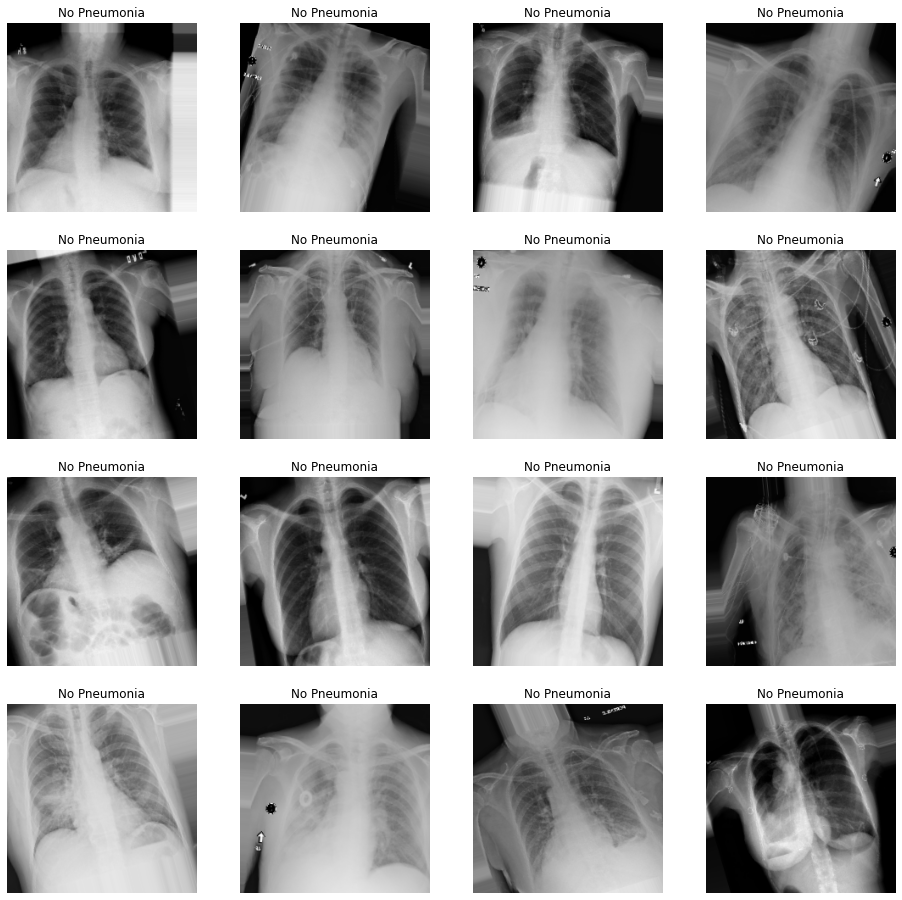

In [3]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# Set constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define Image Data Generators
def image_augmentation():
    return ImageDataGenerator(
        rescale=1/255.0,
        horizontal_flip=True,
        vertical_flip=False,
        height_shift_range=0.1,
        width_shift_range=0.1,
        rotation_range=20,
        shear_range=0.1, 
        zoom_range=0.1
    )

def make_gen(idg, df, class_mode='raw', shuffle=True):
    assert 'path' in df.columns, "Column 'path' is missing from DataFrame"
    assert 'Pneumonia' in df.columns, "Column 'Pneumonia' is missing from DataFrame"
    
    return idg.flow_from_dataframe(
        dataframe=df,
        directory=None,  # Ensure directory is None if 'path' is absolute
        x_col='path',
        y_col='Pneumonia',
        class_mode=class_mode,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

# Create data generators
train_gen = make_gen(image_augmentation(), train_df)
val_gen = make_gen(ImageDataGenerator(rescale=1/255.0), val_df, shuffle=False)

# Visualize augmented data
def visualize_augmented_data(generator, num_images=16):
    t_x, t_y = next(generator)
    fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))
    for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
        c_ax.imshow(c_x)
        c_ax.set_title('Pneumonia' if np.argmax(c_y) == 1 else 'No Pneumonia')
        c_ax.axis('off')
    plt.show()

visualize_augmented_data(train_gen)


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import json
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Load and build model

def load_pretrained_model(layer_of_interest="block5_pool"):
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    for layer in vgg_model.layers[:15]:
        layer.trainable = False
    return vgg_model


def build_my_model():
    base_model = load_pretrained_model()
    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model


my_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)



# Print model summary
my_model.summary()

# Save model architecture to JSON
model_json = my_model.to_json()
with open("xray_class_my_model_architecture.json", "w") as json_file:
    json_file.write(model_json)

print("Model architecture saved to 'xray_class_my_model_architecture.json'.")


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 74 steps, validate for 40 steps
Epoch 1/20
74/74 [==============================] - 85s 1s/step - loss: 10.1501 - accuracy: 0.4932 - val_loss: 4.2957 - val_accuracy: 0.2000
Epoch 2/20
74/74 [==============================] - 77s 1s/step - loss: 2.8681 - accuracy: 0.4864 - val_loss: 1.9382 - val_accuracy: 0.2000
Epoch 3/20
74/74 [==============================] - 77s 1s/step - loss: 1.5295 - accuracy: 0.5025 - val_loss: 1.2342 - val_accuracy: 0.8000
Epoch 4/20
74/74 [==============================] - 77s 1s/step - loss: 1.0833 - accuracy: 0.4767 - val_loss: 0.9636 - val_accuracy: 0.8000
Epoch 5/20
74/74 [==============================] - 77s 1s/step - loss: 0.8967 - accuracy: 0.4915 - val_loss: 0.8430 - val_accuracy: 0.2000
Epoch 6/20
74/74 [==============================] - 78s 1s/step - loss: 0.8081 - accuracy: 0.4902 - val_loss: 0.7798 - val_accuracy: 0.8000
Epoch 7/20
74/74 [==============================] - 77s 1s/step - l

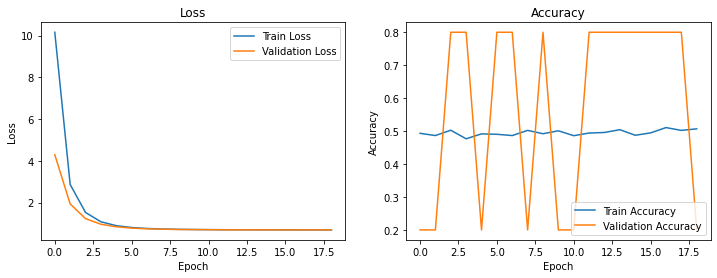

In [5]:
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

# Custom checkpoint callback
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=1):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.best = float('inf')
    
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        
        current = logs.get(self.monitor)
        
        # Save weights if the monitored metric improves
        if current < self.best:
            self.best = current
            self.model.save_weights(self.filepath)
            if self.verbose > 0:
                print(f"Epoch {epoch + 1}: {self.monitor} improved to {self.best:.4f}. Saving weights to {self.filepath}.")

# Define paths and callbacks
weight_path = "xray_class_my_model_best_weights.hdf5"
callbacks_list = [
    CustomModelCheckpoint(filepath=weight_path, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]

# Train the model with the callbacks
history = my_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks_list
)

# Optionally, plot the training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

plot_training_history(history)


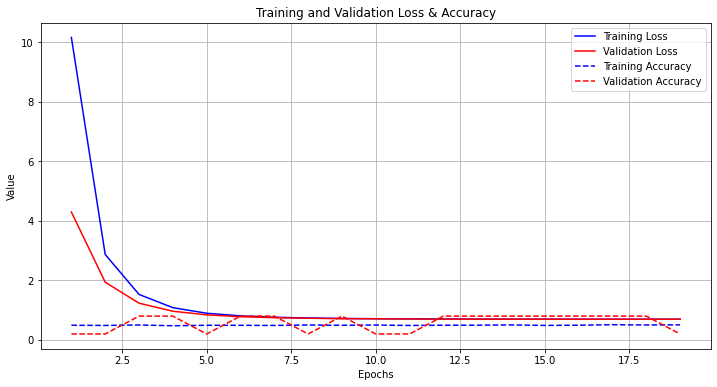

In [6]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    epochs_range = range(1, len(history.history['loss']) + 1)
    
    # Plot training and validation loss
    plt.plot(epochs_range, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss')
    
    # Plot training and validation accuracy
    plt.plot(epochs_range, history.history['accuracy'], 'b--', label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], 'r--', label='Validation Accuracy')
    
    # Add titles and labels
    plt.title('Training and Validation Loss & Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend(loc='best')
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Call the function to plot
plot_training_history(history)


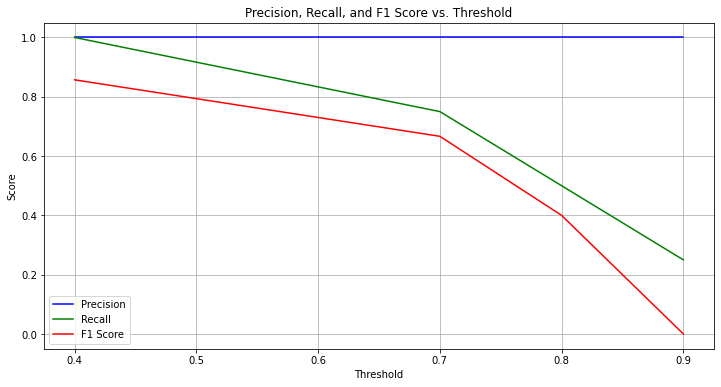

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Sample data (replace with actual data)
val_labels = np.array([0, 1, 0, 1, 0, 1, 0, 1])
val_predictions = np.array([0.1, 0.4, 0.2, 0.8, 0.3, 0.7, 0.2, 0.9])

# Compute Precision, Recall, and F1 Score at various thresholds
precision, recall, thresholds = precision_recall_curve(val_labels, val_predictions)
f1_scores = [f1_score(val_labels, val_predictions > t) for t in thresholds]

# Plot Precision, Recall, and F1 Score vs. Threshold
plt.figure(figsize=(12, 6))

# Plot Precision
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')

# Plot Recall
plt.plot(thresholds, recall[:-1], label='Recall', color='green')

# Plot F1 Score
plt.plot(thresholds, f1_scores, label='F1 Score', color='red')

# Add labels and title
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [8]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# Function to find the best threshold based on a balance of precision, recall, and F1 score
def find_best_threshold(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = [f1_score(y_true, y_scores > t) for t in thresholds]

    # Determine the best threshold by maximizing F1 score
    best_f1_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_f1_index]
    best_precision = precision[best_f1_index]
    best_recall = recall[best_f1_index]
    best_f1_score = f1_scores[best_f1_index]

    return best_threshold, best_precision, best_recall, best_f1_score

# Compute Precision, Recall, and F1 Score at various thresholds
best_threshold, best_precision, best_recall, best_f1_score = find_best_threshold(val_labels, val_predictions)

print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best Precision: {best_precision:.4f}')
print(f'Best Recall: {best_recall:.4f}')
print(f'Best F1 Score: {best_f1_score:.4f}')


Best Threshold: 0.4000
Best Precision: 1.0000
Best Recall: 1.0000
Best F1 Score: 0.8571


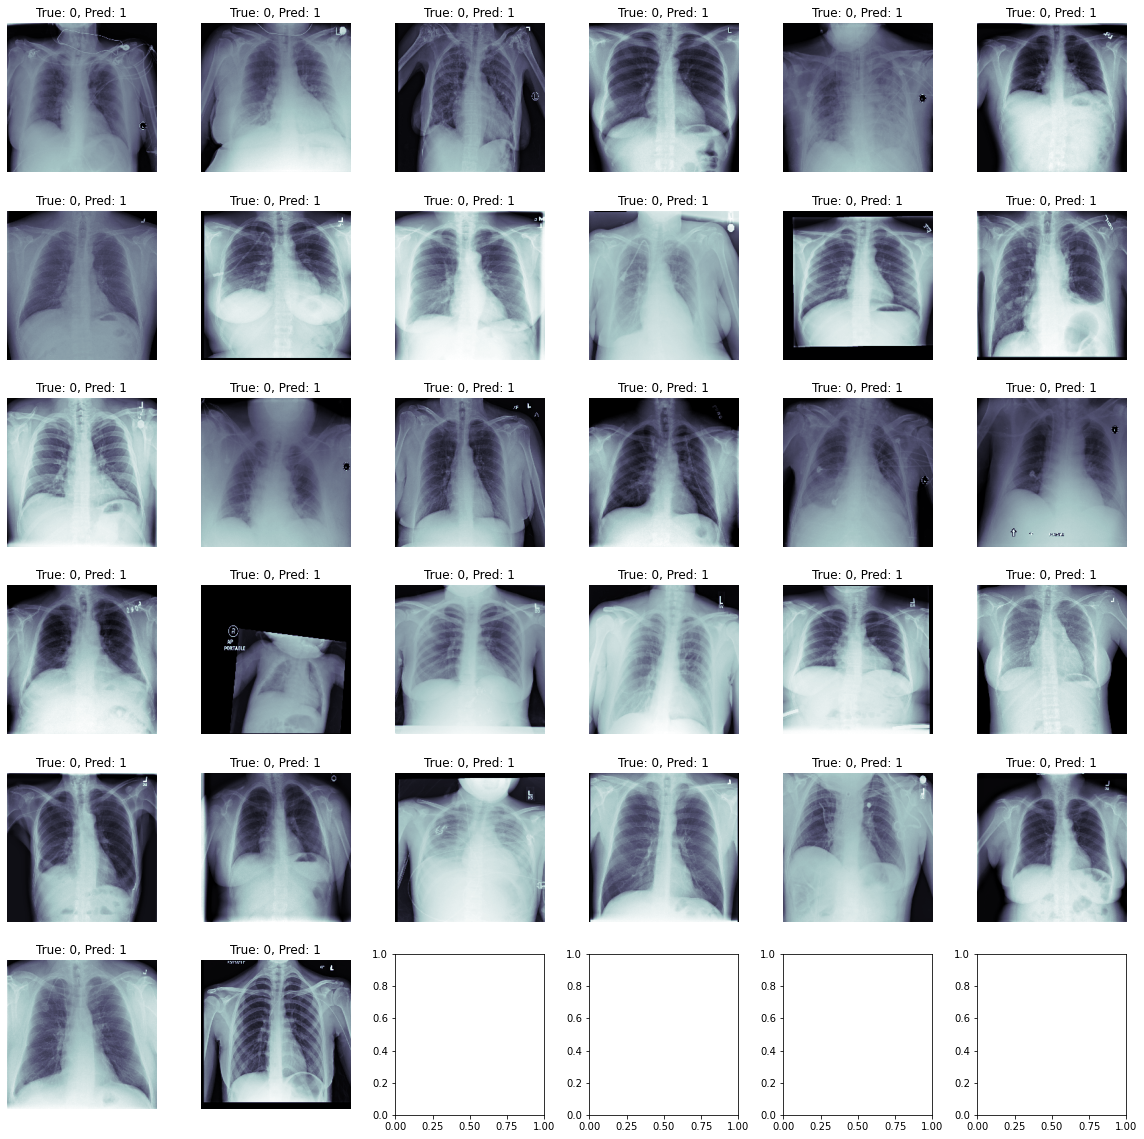

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assume `val_gen` is your validation data generator and `my_model` is your trained model.

# Get a batch of validation images
testX, testY = val_gen.next()

# Generate predictions for the batch
pred_Y = my_model.predict(testX).flatten()

# Plot true vs. predicted labels
fig, m_axs = plt.subplots(6, 6, figsize=(16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(testX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:, :, 0], cmap='bone')
    
    # True and predicted labels
    true_label = int(c_y)
    predicted_label = int(pred_Y[i] > 0.3709)  # Use the specified threshold
    
    c_ax.set_title(f'True: {true_label}, Pred: {predicted_label}')
    c_ax.axis('off')
    i += 1

plt.tight_layout()
plt.show()


In [10]:
model_json = my_model.to_json()
with open("xray_class_my_model_architecture.json", "w") as json_file:
    json_file.write(model_json)
print("Model architecture saved to 'xray_class_my_model_architecture.json'.")

Model architecture saved to 'xray_class_my_model_architecture.json'.


In [11]:
# Save model weights to HDF5
my_model.save_weights("xray_class_my_model_best_weights.hdf5")
print("Model weights saved to 'xray_class_my_model_best_weights.hdf5'.")

Model weights saved to 'xray_class_my_model_best_weights.hdf5'.
